<a href="https://colab.research.google.com/github/cubrictiff/Machine-Learning/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Exploring**

In [0]:
import csv
import pandas as pd

with open('drive/My Drive/Sentiment Analysis/train.tsv') as doc:
    rd = csv.reader(doc, delimiter="\t", quotechar='"')
    col = ['PhraseId','SentenceId','Phrase','Sentiment']
    df = pd.DataFrame(rd, columns = col)
df = df.iloc[1:]
df = df.reset_index()
df 

,index,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,1,A series of escapades demonstrating the adage ...,1
1,2,2,1,A series of escapades demonstrating the adage ...,2
2,3,3,1,A series,2
3,4,4,1,A,2
4,5,5,1,series,2
...,...,...,...,...,...
156055,156056,156056,8544,Hearst 's,2
156056,156057,156057,8544,forced avuncular chortles,1
156057,156058,156058,8544,avuncular chortles,3
156058,156059,156059,8544,avuncular,2


In [0]:
phrase = df['Phrase']
phrase[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
dtype: int64


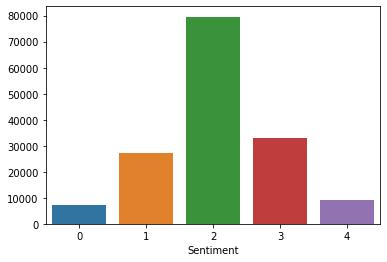

In [0]:
import seaborn as sns
sent = df.groupby(['Sentiment']).size()
sns.barplot(sent.keys(),sent.values)

In [0]:
import numpy as np
import nltk

phrase[0].split()

['A',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 ',',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story',
 '.']

**Data Preparation**

In [0]:
import string
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
  


def to_lowercase(words):
    word_lst = []
    for word in words:
        word = word.lower()
        word_lst.append(word)
    return word_lst

def remove_punctuation(words):
    word_lst = []
    table = str.maketrans(dict.fromkeys(string.punctuation))
    for word in words:
        word = word.translate(table)
        word_lst.append(word)
    word_lst = [x for x in word_lst if x]
    return word_lst

def remove_num(words):
    word_lst = []
    for word in words:
        if not word.isdigit():
            word_lst.append(word)
    return word_lst

def remove_stopword(words):
    word_lst = []
    for word in words:
        if word not in stopwords.words('english'):
            word_lst.append(word)
    return word_lst

def stem_word(words):
    stemmer = LancasterStemmer()
    word_lst = []
    for word in words:
        word = stemmer.stem(word)
        word_lst.append(word)
    return word_lst

def lemmatize_word(words):
    lemmatizer = WordNetLemmatizer()
    word_lst = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        word_lst.append(lemma)
    return word_lst

def normalize_word(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_num(words)
    words = remove_stopword(words)
    words = stem_word(words)
    words = lemmatize_word(words)
    
    return words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
df['Token'] = df['Phrase'].apply(nltk.word_tokenize) 

In [0]:
df['Token'] = df['Token'].apply(normalize_word)

In [0]:
word_set = set()
for word in df['Token']:
    for i in word:
        word_set.add(i)
word_dict = {word:i for i, word in enumerate(word_set,1)}

df['Token'] = df['Token'].apply(lambda l: [word_dict[word] for word in l])
df['Token']

long_word = df['Token'].str.len().max()
long_word

all_token = np.array([i for i in df['Token']])
df['Sentiment'] = df['Sentiment'].astype('int')
label = np.array([i for i in df['Sentiment']])
feature = np.zeros((len(all_token),long_word), dtype = int)

for i,words in enumerate(df['Token']):
    feature[i,:len(words)] = words

In [0]:
split = 0.8

train_index = int(len(feature)*0.8)
x_train, x_remain = feature[:train_index], feature[train_index:]
y_train, y_remain = label[:train_index], label[train_index:]

test_index = int(len(x_remain)*0.5)
x_validate, x_test = x_remain[:test_index], x_remain[test_index:]
y_validate, y_test = y_remain[:test_index], y_remain[test_index:]


In [0]:
print(type(y_train[0]))
print(x_test.shape)
print(x_validate.shape)

<class 'numpy.int64'>
(15606, 30)
(15606, 30)


**Model** **Building** 

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [0]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
validate_data = TensorDataset(torch.from_numpy(x_validate), torch.from_numpy(y_validate))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

In [0]:
batch_size  = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(validate_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [0]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
class SentimentRNN(nn.Module):

  def __init__(self,vocab_size, output_size,embedding_dim,
               hiddent_dim,n_layers,drop_prob=0.5):

    super(SentimentRNN,self).__init__()

    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    # embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,
                        dropout=drop_prob, batch_first = True)
    
    # dropout layer
    self.dropout = nn.Dropout(0.3)
    
    # linear
    self.fc = nn.Linear(hidden_dim,output_size)

  def forward(self, x, hidden):

    batch_size = x.size(0)

    embeds = self.embedding(x)

    lstm_out, hidden = self.lstm(embeds, hidden)

    lstm_out = lstm_out.transpose(0,1)
    lstm_out = lstm_out[-1]

    out = self.dropout(lstm_out)
    out = self.fc(out)

    return out, hidden
  
  def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
            
        return hidden



In [0]:
vocab_size = len(word_set) + 1
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(9891, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [0]:
lr=0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

**Training**

In [0]:
# training params
epochs = 3 
counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()

for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
               val_h = tuple([each.data for each in val_h])

                
               inputs, labels = inputs.cuda(), labels.cuda()

               output, val_h = net(inputs, val_h)
               val_loss = criterion(output, labels)

               val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 1.348261... Val Loss: 1.301404
Epoch: 1/3... Step: 200... Loss: 1.275716... Val Loss: 1.303926
Epoch: 1/3... Step: 300... Loss: 1.283561... Val Loss: 1.310805
Epoch: 1/3... Step: 400... Loss: 1.319135... Val Loss: 1.303073
Epoch: 1/3... Step: 500... Loss: 1.334146... Val Loss: 1.301840
Epoch: 1/3... Step: 600... Loss: 1.136655... Val Loss: 1.303479
Epoch: 1/3... Step: 700... Loss: 1.276804... Val Loss: 1.303246
Epoch: 1/3... Step: 800... Loss: 1.238992... Val Loss: 1.268387
Epoch: 1/3... Step: 900... Loss: 1.230065... Val Loss: 1.235794
Epoch: 1/3... Step: 1000... Loss: 1.130429... Val Loss: 1.232271
Epoch: 1/3... Step: 1100... Loss: 1.300996... Val Loss: 1.206121
Epoch: 1/3... Step: 1200... Loss: 1.315115... Val Loss: 1.199940
Epoch: 1/3... Step: 1300... Loss: 1.283123... Val Loss: 1.194853
Epoch: 1/3... Step: 1400... Loss: 1.106670... Val Loss: 1.184140
Epoch: 1/3... Step: 1500... Loss: 1.073022... Val Loss: 1.170003
Epoch: 1/3... Step: 1600... Loss: 

In [0]:
test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)

net.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))


Test loss: 1.099
Test accuracy: 0.560
